In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/grocery-sales-forecast/sub.csv
/kaggle/input/grocery-sales-forecast/train.csv
/kaggle/input/grocery-sales-forecast/test.csv


In [2]:
!mkdir /kaggle/working/prepared_data

In [3]:
grocary_df = pd.read_csv('../input/grocery-sales-forecast/train.csv')
grocary_df.head(3)

,warehouse_id,product_id,date,quantity,id
0,0,71165,2020-12-02,1,0
1,0,71165,2020-12-03,3,1
2,0,71165,2020-12-07,2,2


In [4]:
grocary_df.describe()

,warehouse_id,product_id,quantity,id
count,78067.000000,78067.000000,78067.000000,78067.000000
mean,0.618379,84437.432526,1.832067,41445.083351
std,0.485787,7171.067292,2.044832,23896.691729
min,0.000000,71165.000000,1.000000,0.000000
25%,0.000000,77820.000000,1.000000,20634.500000
50%,1.000000,85525.000000,1.000000,41642.000000
75%,1.000000,90180.000000,2.000000,62112.500000
max,1.000000,98635.000000,79.000000,83158.000000


In [5]:
grocary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78067 entries, 0 to 78066
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   warehouse_id  78067 non-null  int64 
 1   product_id    78067 non-null  int64 
 2   date          78067 non-null  object
 3   quantity      78067 non-null  int64 
 4   id            78067 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.0+ MB


In [6]:
dfw0 = grocary_df[grocary_df.warehouse_id == 0].drop('warehouse_id', axis=1)
dfw1 = grocary_df[grocary_df.warehouse_id == 1].drop('warehouse_id', axis=1)

In [7]:
unique0 = dfw0['product_id'].unique()
unique1 = dfw1['product_id'].unique()
unique0.shape, unique1.shape
np.savetxt('unique1.csv', unique1, delimiter=',', fmt='%d')

In [8]:
def prepare_warehouse_0():
    for p_id in tqdm(unique0):
        d0 = dfw0[dfw0.product_id == p_id].reset_index(drop=True)
        cur_id = d0['product_id'][0]
        d0 = d0.drop(columns=['id', 'product_id'])
        min_date_time = datetime.strptime(d0['date'].min(), '%Y-%m-%d')
        max_date_time = datetime.strptime('2021-04-08', '%Y-%m-%d')
        dates = d0['date'].values
        while min_date_time != max_date_time:
            min_date_time += timedelta(days=1)
            date = datetime.strftime(min_date_time, '%Y-%m-%d')
            if date not in dates:
                d0 = d0.append({'date':date, 'quantity':0}, ignore_index=True)
        d0 = d0.sort_values('date').reset_index(drop=True)
        d0.to_csv(f"/kaggle/working/prepared_data/0_{cur_id}.csv")
prepare_warehouse_0()

100%|██████████| 2474/2474 [07:14<00:00,  5.69it/s]


In [9]:
def prepare_warehouse_1():
    for p_id in tqdm(unique1):
        d1 = dfw1[dfw1.product_id == p_id].reset_index(drop=True)
        cur_id = d1['product_id'][0]
        d1 = d1.drop(columns=['id', 'product_id'])
        min_date_time = datetime.strptime(d1['date'].min(), '%Y-%m-%d')
        max_date_time = datetime.strptime('2021-04-08', '%Y-%m-%d')
        dates = d1['date'].values
        while min_date_time != max_date_time:
            min_date_time += timedelta(days=1)
            date = datetime.strftime(min_date_time, '%Y-%m-%d')
            if date not in dates:
                d1 = d1.append({'date':date, 'quantity':0}, ignore_index=True)
        d1 = d1.sort_values('date').reset_index(drop=True)
        d1.to_csv(f"/kaggle/working/prepared_data/1_{cur_id}.csv")
prepare_warehouse_1()

100%|██████████| 3034/3034 [09:56<00:00,  5.09it/s]


In [10]:
d0 = pd.read_csv('/kaggle/working/prepared_data/0_83500.csv')
d1 = pd.read_csv('/kaggle/working/prepared_data/1_83500.csv')

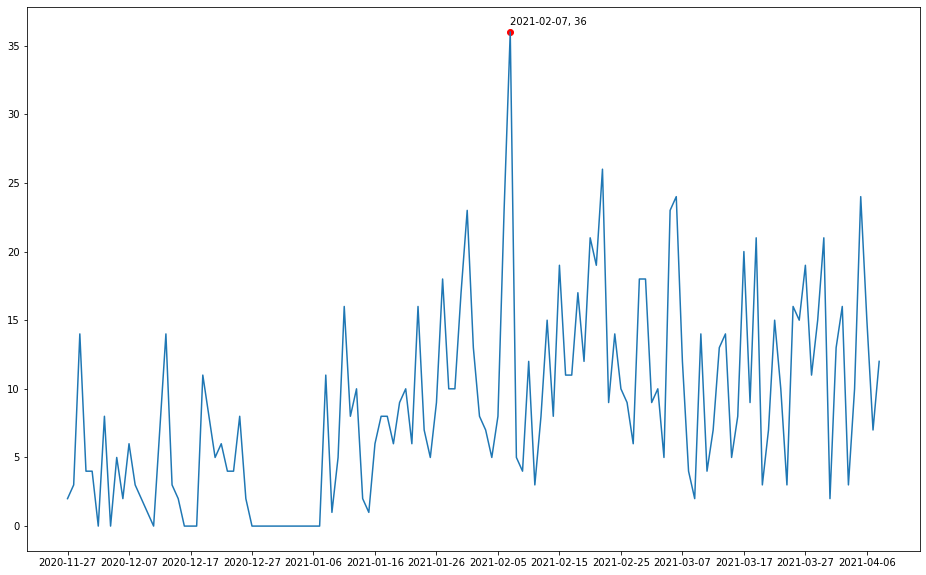

In [11]:
fig = plt.figure(figsize=(16, 10))
plt.plot(d0['date'], d0['quantity'])
maxidx = d0['quantity'].argmax()
plt.scatter(d0['date'][maxidx], d0['quantity'][maxidx], c='red')
plt.text(d0['date'][maxidx], d0['quantity'][maxidx] + 0.5, f"{d0['date'][maxidx]}, {d0['quantity'][maxidx]}")
_ = plt.xticks(d0['date'][::10])

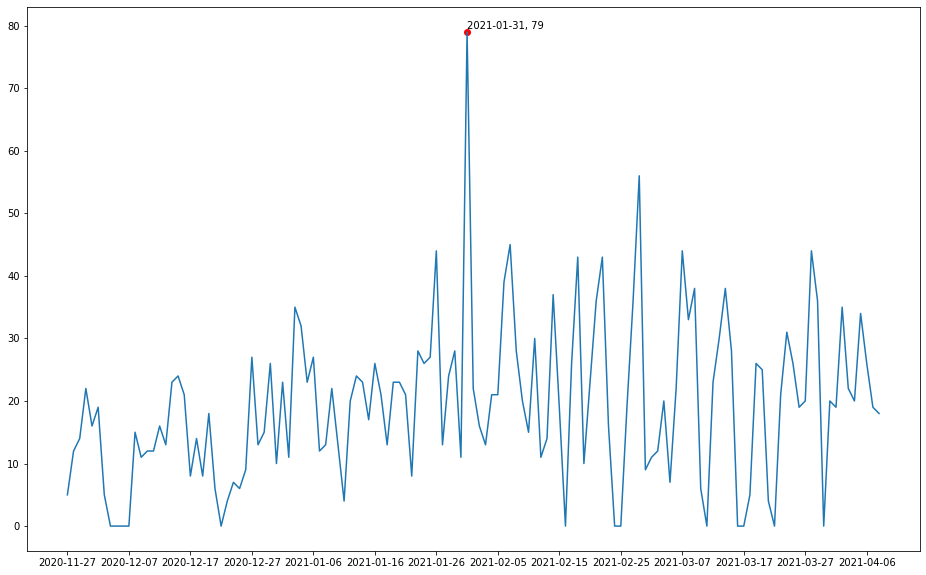

In [12]:
fig = plt.figure(figsize=(16, 10))
plt.plot(d1['date'], d1['quantity'])
maxidx = d1['quantity'].argmax()
plt.scatter(d1['date'][maxidx], d1['quantity'][maxidx], c='red')
plt.text(d1['date'][maxidx], d1['quantity'][maxidx] + 0.5, f"{d1['date'][maxidx]}, {d1['quantity'][maxidx]}")
_ = plt.xticks(d1['date'][::10])

In [13]:
df = pd.read_csv('../input/grocery-sales-forecast/test.csv')
df.head()

,date,product_id,warehouse_id,id
0,2021-04-09,71165,0,0
1,2021-04-09,71165,1,1
2,2021-04-09,71170,0,2
3,2021-04-09,71170,1,3
4,2021-04-09,71185,0,4


In [14]:
answers = np.empty((6576 * 7, 2), dtype=int)
answers[:, 0] = np.arange(6576 * 7)
for i in tqdm(range(6576)):
    row = df.loc[i]
    try:
        forecasted_product = pd.read_csv(f"/kaggle/working/prepared_data/{row['warehouse_id']}_{row['product_id']}.csv")
        tmp = forecasted_product['quantity'].to_numpy()
        if tmp.shape[0] > 1:
            fit = SimpleExpSmoothing(tmp).fit(smoothing_level=0.35)
            next_week = fit.forecast(7)
            next_week = np.maximum(np.rint(next_week), np.zeros((7,)))
        else:
            next_week = np.zeros((7,))
    except FileNotFoundError:
        next_week = np.zeros((7, ))
    for j in range(next_week.shape[0]):
        answers[i + j * 6576, 1] = next_week[j]

  0%|          | 0/6576 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
 98%|█████████▊| 6464/6576 [00:41<00:00, 200.75it/s]/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:1439: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:1444: RuntimeWarning: invalid value encountered in double_scalars
  aicc = aic + aicc_penalty
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:1445: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
100%|██████████| 6576/6576 [00:42<00:00, 156.52it/s]


In [15]:
df2 = pd.DataFrame(answers, columns=['id', 'quantity'])
df2.to_csv('/kaggle/working/submission.csv', index=False)

In [16]:
!rm -rf /kaggle/working/prepared_data